# Exploring high-resolution population density data for Slovakia
Data downloaded from Humdata/HDX/Facebook: https://data.humdata.org/dataset/slovakia-high-resolution-population-density-maps-demographic-estimates

This data set contains the estimated population density at different points of latitude and longitude for Slovakia.

In this notebook I am performing some basic visualisations of the data, and comparing population density to locations of reports of illegal dumpsites to TrashOut.

The aims are:
*   To assess whether this data set might be useful for building features for a machine learning model to predict new dumpsites
*   To get an early idea of whether dumpsites do tend to appear in (or close to) areas of high population density

In [ ]:
# Mount data from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Basic exploration and visualisation of the data set

['population_svk_2019-07-01.tif', 'population_svk_2019-07-01.tif.aux.xml', 'population_svk_2019-07-01.csv', 'population_svk_2019-07-01.csv.zip']
Shape of data set: (2399181, 3)
         Lat        Lon  Population
0  47.853750  18.492917    1.408203
1  47.860972  18.554306    1.165788
2  47.917917  18.585417    1.036386
3  47.797639  18.590972    1.393990
4  47.813194  18.639028    1.135845
5  47.914861  18.639861    1.367727
6  47.969306  18.649861    1.179417
7  47.971806  18.654583    1.179417
8  47.847361  18.661806    1.135845
9  47.847083  18.662917    1.135845

0 nans in latitude
0 nans in longitude
0 nans in population


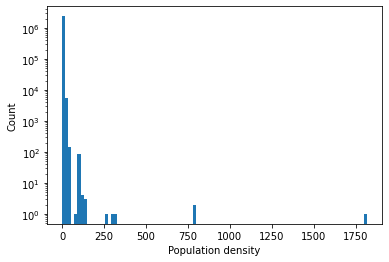

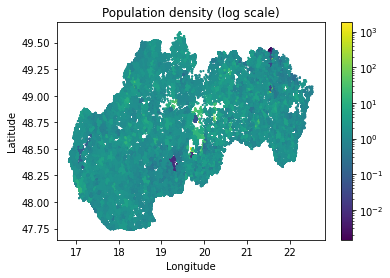

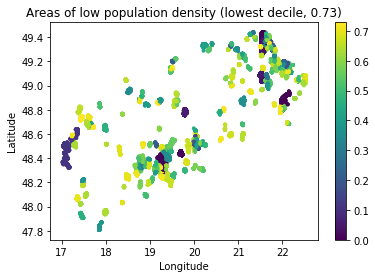

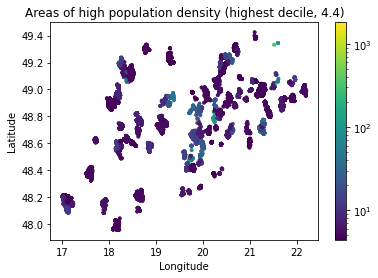

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Set working directory and load data
os.chdir(("drive/My Drive/TrashOut/Population density data"))
# !unzip 'population_svk_2019-07-01.csv.zip'
print(os.listdir())
svk = pd.read_csv('population_svk_2019-07-01.csv', error_bad_lines=False, sep=',')

# Inspect csv
print("Shape of data set: " + str(svk.shape))
print(svk.head(10))
print()
print(str(svk['Lat'].isna().sum()) + ' nans in latitude')
print(str(svk['Lon'].isna().sum()) + ' nans in longitude')
print(str(svk['Population'].isna().sum()) + ' nans in population')

# Plot histogram of population density
plt.figure()
plt.hist(svk['Population'], bins=100)
plt.yscale('log')
plt.xlabel('Population density')
plt.ylabel('Count')

# Plot log of population density
plt.figure()
sc = plt.scatter(x=svk.loc[:,'Lon'], y=svk.loc[:,'Lat'], c=svk.loc[:,'Population'], s=5, norm=colors.LogNorm(), marker='.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Population density (log scale)')
plt.colorbar(sc)
plt.show()

# Plot areas of low population density (lowest decile)
threshold = np.quantile(svk['Population'], 0.1)
i = svk.loc[:,'Population'] < threshold
plt.figure()
sc = plt.scatter(x=svk.loc[i,'Lon'], y=svk.loc[i,'Lat'], c=svk.loc[i,'Population'], norm=colors.Normalize(), marker='.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Areas of low population density (lowest decile, ' + str(round(threshold,2)) + ')')
plt.colorbar(sc)
plt.show()

# Plot areas of high population density (highest decile)
threshold = np.quantile(svk['Population'], 0.9)
i = svk.loc[:,'Population'] > threshold
plt.figure()
sc = plt.scatter(x=svk.loc[i,'Lon'], y=svk.loc[i,'Lat'], c=svk.loc[i,'Population'], norm=colors.LogNorm(), marker='.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Areas of high population density (highest decile, ' + str(round(threshold,2)) + ')')
plt.colorbar(sc)
plt.show()

Data set contains latitude, longitude and population density in 23,99,181 locations. I can't find documentation indicating what unit the population density is in, so I can only assume people per kilometre. Population density is highly skewed, with 90% of locations having a population density below 4.4, and a small number of areas with population density in the hundreds (which presumably correspond to city centres). Areas of high and low density are pretty scattered throughout the country.

# 2. Estimate spatial resolution
It is useful to know the spatial resolution for determining what information this data set can and can't provide. We can do this by calculating the distance between latitude and longitude points.

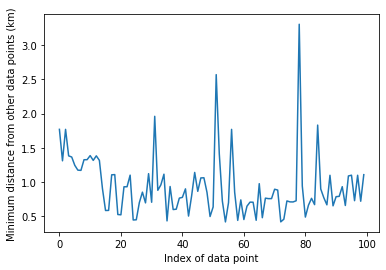

Mean distance between data points is 0.93 km


In [ ]:
# Find minimum distance in km between each lat/lon and every other lat/lon. Will take too long to do this for every single data point, so just find the minimum distance for the first 100 data points

import numpy as np

distance = []

for i in range(100):

  # Get longitude and latitude for each data point
  lon = np.array(svk.iloc[i,1])
  lat = np.array(svk.iloc[i,0])

  # Get the indices for all data points except the current one
  other_indices = [j for j in range(svk.shape[0])]
  other_indices.remove(i)

  # Get longitude and latitude for these other data points
  lon2 = np.array(svk.iloc[other_indices,1])
  lat2 = np.array(svk.iloc[other_indices,0])

  # Use Haversine formula to calculate distance in km
  dlon = lon - lon2
  dlat = lat - lat2
  a = np.sin(dlat/2)**2 + np.cos(lat) * np.cos(lat2) * np.sin(dlon/2)**2
  d =  6371 * 2 * np.arcsin(np.sqrt(a))

  # Record the minimum distance
  distance.append(min(d))

plt.plot(distance)
plt.xlabel('Index of data point')
plt.ylabel('Minimum distance from other data points (km)')
plt.show()
print("Mean distance between data points is " + str(round(np.mean(distance),2)) + " km")

Resolution is ~1 km. This can help identify cities and even small towns, it can also identify built-up areas within cities and towns.

# 3. Check for a simple association between population density and dumpsite location
Do dumpsites occur more often in places of high population density? Compare the latitude and longitude of TrashOut reports with the population density data.

In [ ]:
# Load TrashOut data for Slovakia

# Move to the right directory
os.chdir("../")
print(os.listdir())

all_data = pd.read_csv('AllData_ManualEdits.csv', error_bad_lines=False, sep=',')

# Extract reports for Slovakia
svk_trashout = all_data.loc[all_data.loc[:,"country"] == "Slovakia", :]
print("\nExtracted " + str(svk_trashout.shape[0]) + " reports for Slovakia\n")
svk_trashout.head()

['AllData_ManualEdits.csv', 'europe_1.csv', 'europe_2.csv', 'europe_0.csv', 'europe_5.csv', 'europe_3.csv', 'europe_8.csv', 'europe_7.csv', 'europe_4.csv', 'europe_6.csv', 'africa_1.csv', 'africa_0.csv', 'asia_0.csv', 'australia_0.csv', 'northamerica_1.csv', 'northamerica_0.csv', 'oceania_0.csv', 'southamerica_0.csv', 'Population density data']

Extracted 7798 reports for Slovakia



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,id,latitude,longitude,continent,country,aa1,aa2,aa3,locality,subLocality,types,updateTime,updateNeeded,note,url,status,size,anonymous,created,accessibility,image
7205,0,57835,48.694450,21.875917,Europe,Slovakia,Košický kraj,Michalovce,NaN,Vrbnica,Vrbnica,"plastic,domestic",2020-06-23T08:42:16.612Z,False,NaN,https://admin.trashout.ngo/trash-management/de...,stillHere,wheelbarrow,TRUE,2020-06-23T08:42:16.612Z,NaN,https://firebasestorage.googleapis.com/v0/b/tr...
7211,6,57820,48.676622,17.861397,Europe,Slovakia,Trenčiansky kraj,Nové Mesto nad Váhom,NaN,Brunovce,Brunovce,"plastic,domestic",2020-06-21T15:47:28.400Z,False,NaN,https://admin.trashout.ngo/trash-management/de...,stillHere,bag,TRUE,2020-06-21T15:47:28.400Z,byCar,https://firebasestorage.googleapis.com/v0/b/tr...
7212,7,57819,48.680297,17.870076,Europe,Slovakia,Trenčiansky kraj,Nové Mesto nad Váhom,NaN,Brunovce,Brunovce,domestic,2020-06-21T14:50:20.533Z,False,NaN,https://admin.trashout.ngo/trash-management/de...,stillHere,bag,TRUE,2020-06-21T14:50:20.533Z,byCar,https://firebasestorage.googleapis.com/v0/b/tr...
7232,27,57779,48.825100,21.567755,Europe,Slovakia,Prešovský kraj,Vranov nad Topľou,NaN,Banské,Banské,"deadAnimals,dangerous,liquid,metal,electronic,...",2020-06-17T15:49:50.563Z,False,NaN,https://admin.trashout.ngo/trash-management/de...,stillHere,car,FALSE,2020-06-17T15:49:50.563Z,byCar,https://firebasestorage.googleapis.com/v0/b/tr...
7239,34,57769,47.770878,18.499916,Europe,Slovakia,Nitriansky kraj,Komárno,NaN,Kravany nad Dunajom,Kravany nad Dunajom,"glass,dangerous,metal,electronic,plastic,const...",2020-06-16T18:14:03.440Z,False,nearby a farm. between Volařik farm and Dalas ...,https://admin.trashout.ngo/trash-management/de...,stillHere,car,FALSE,2020-06-16T18:14:03.440Z,byCar,https://firebasestorage.googleapis.com/v0/b/tr...


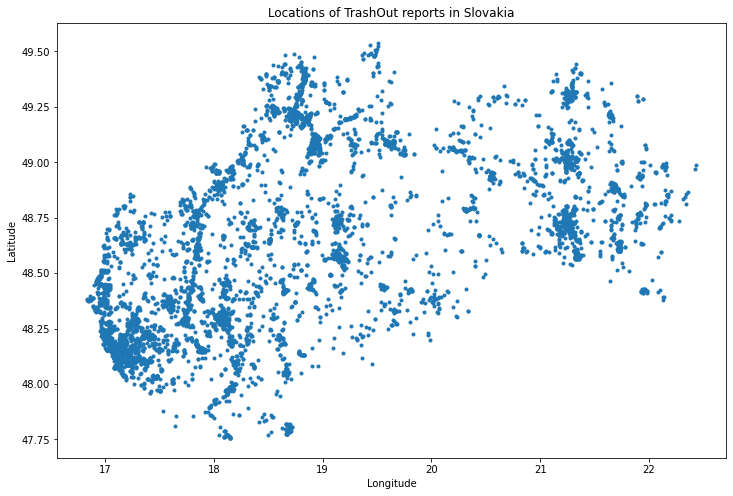

In [ ]:
# Visualise where the reports are
plt.figure(figsize=(12,8))
plt.scatter(x=svk_trashout.loc[:,'longitude'], y=svk_trashout.loc[:,'latitude'], marker='.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Locations of TrashOut reports in Slovakia')
plt.show()

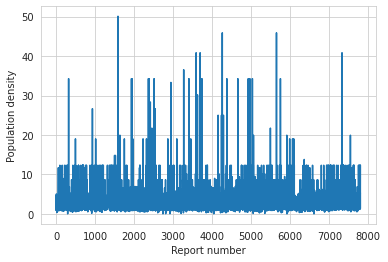

In [ ]:
# Find nearest population density data point for every report

pop_den = []

for i in range(svk_trashout.shape[0]):

  # Get report's latitude and longitude
  lat = svk_trashout.iloc[i,2]
  lon = svk_trashout.iloc[i,3]

  # Find distance between report and population density data points using Haversine formula
  dlon = lon - svk['Lon']
  dlat = lat - svk['Lat']
  a = np.sin(dlat/2)**2 + np.cos(lat) * np.cos(svk['Lat']) * np.sin(dlon/2)**2
  d = 6371 * 2 * np.arcsin(np.sqrt(a))

  # Record population density corresponding to closest lat & lon
  pop_den.append(float(svk.iloc[np.where(d == np.amin(d))[0][0],2]))


plt.figure()
plt.plot(pop_den)
plt.xlabel('Report number')
plt.ylabel('Population density')
plt.show()

Mean population density in Slovakia:    2.2654800720868207
Mean population density near dumpsites: 3.2730351293879876
Wilcoxon's rank-sum test on population density difference between all Slovakia and dumpsite locations:
RanksumsResult(statistic=-39.53391728441701, pvalue=0.0)


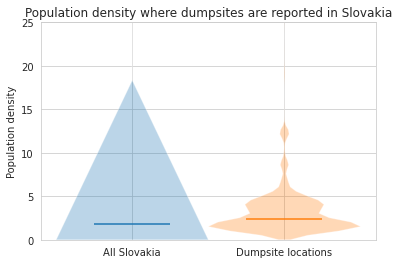

In [ ]:
# Plot and compare distributions of all population densities in Slovakia, and population density near TrashOut reports
print("Mean population density in Slovakia:    " + str(np.mean(svk['Population'])))
print("Mean population density near dumpsites: " + str(np.mean(pop_den)))

from scipy.stats import ranksums
print("Wilcoxon's rank-sum test on population density difference between all Slovakia and dumpsite locations:")
print(ranksums(svk['Population'], pop_den))

plt.figure()
plt.violinplot(svk['Population'], positions=[1], widths=1, showmeans=False, showmedians=True, showextrema=False)
plt.violinplot(pop_den, positions=[2], widths=1, showmeans=False, showmedians=True, showextrema=False)
plt.title('Population density where dumpsites are reported in Slovakia')
plt.ylim(0, 25)
plt.xticks(ticks=[1,2], labels=['All Slovakia', 'Dumpsite locations'])
plt.ylabel('Population density')
plt.show()

plt.show()

Dumpsite locations occur on average in places with higher population densities. More visualisations below to explore this trend futher.

# 4. Check for an association between population density and dumpsite size
Where do the largest dumpsites occur? This is useful for municipalities to know because they may wish to direct more resources towards preventing such sites.

Mean population density in Slovakia:                      2.2654800720868207
Mean population density near dumpsites:                   3.2730351293879876
Mean population density near bag-sized dumpsites:         3.5540062995593447
Mean population density near wheelbarrow-sized dumpsites: 3.3969889623820357
Mean population density near car-sized dumpsites:         3.07546896877321

Kruskal-Wallis test on population density difference between bag-, wheelbarrow- and car-sized dumpsites:
KruskalResult(statistic=25.549846576465498, pvalue=2.8308790158418212e-06)


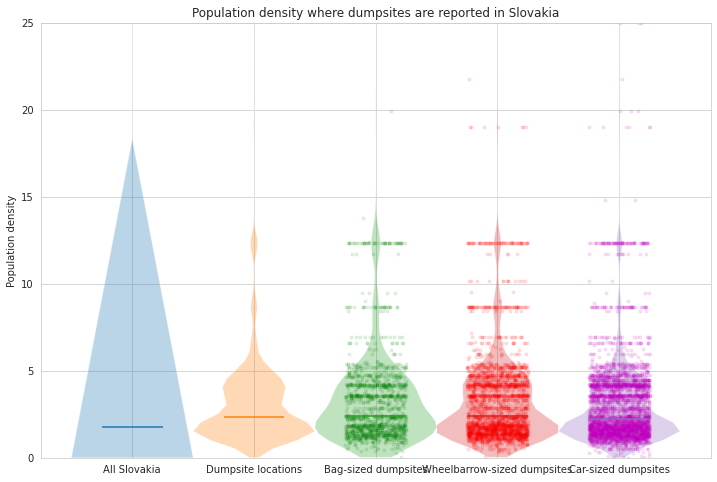

In [ ]:
# Plot distributions of population density for bag-, wheelbarrow- and car-sized dumpsites

bag_reports = svk_trashout['size'] == 'bag'
wb_reports = svk_trashout['size'] == 'wheelbarrow'
car_reports = svk_trashout['size'] == 'car'

print("Mean population density in Slovakia:                      " + str(np.mean(svk['Population'])))
print("Mean population density near dumpsites:                   " + str(np.mean(pop_den)))
print("Mean population density near bag-sized dumpsites:         " + str(np.mean(np.array(pop_den)[bag_reports])))
print("Mean population density near wheelbarrow-sized dumpsites: " + str(np.mean(np.array(pop_den)[wb_reports])))
print("Mean population density near car-sized dumpsites:         " + str(np.mean(np.array(pop_den)[car_reports])))

from scipy.stats import kruskal
print("\nKruskal-Wallis test on population density difference between bag-, wheelbarrow- and car-sized dumpsites:")
print(kruskal(np.array(pop_den)[bag_reports], np.array(pop_den)[wb_reports], np.array(pop_den)[car_reports]))

plt.figure(figsize=(12, 8))
plt.violinplot(svk['Population'], positions=[1], widths=1, showmeans=False, showmedians=True, showextrema=False)
plt.violinplot(pop_den, positions=[2], widths=1, showmeans=False, showmedians=True, showextrema=False)
plt.violinplot(np.array(pop_den)[bag_reports], positions=[3], widths=1, showmeans=False, showmedians=True, showextrema=False)
plt.violinplot(np.array(pop_den)[wb_reports], positions=[4], widths=1, showmeans=False, showmedians=True, showextrema=False)
plt.violinplot(np.array(pop_den)[car_reports], positions=[5], widths=1, showmeans=False, showmedians=True, showextrema=False)
plt.title('Population density where dumpsites are reported in Slovakia')
plt.ylim(0, 25)
plt.xticks(ticks=[1,2,3,4,5], labels=['All Slovakia', 'Dumpsite locations', 'Bag-sized dumpsites', 'Wheelbarrow-sized dumpsites', 'Car-sized dumpsites'])
plt.ylabel('Population density')

# Scatter bag-sized dumpsites over the top
xjitter = np.linspace(2.75, 3.25, sum(bag_reports))
plt.scatter(x=np.random.permutation(xjitter),y=np.array(pop_den)[bag_reports], c='g', marker='.', alpha=0.1)
xjitter = np.linspace(3.75, 4.25, sum(wb_reports))
plt.scatter(x=np.random.permutation(xjitter),y=np.array(pop_den)[wb_reports], c='r', marker='.', alpha=0.1)
xjitter = np.linspace(4.75, 5.25, sum(car_reports))
plt.scatter(x=np.random.permutation(xjitter),y=np.array(pop_den)[car_reports], c='m', marker='.', alpha=0.1)
plt.show()



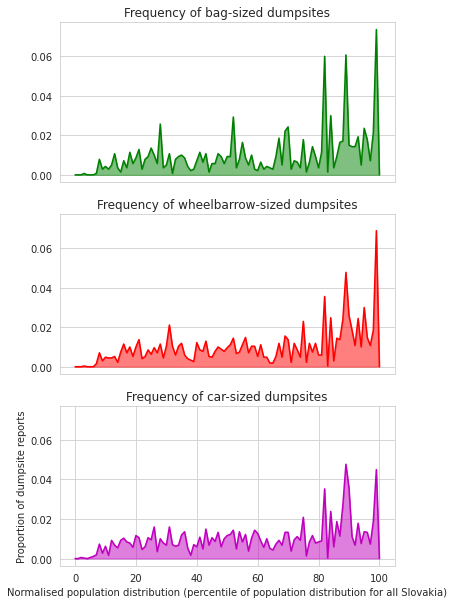

In [ ]:
# Normalise population densities to percentiles of population density for the whole of Slovakia

# Express population densities as percentiles
prctile = svk['Population'].quantile(q=np.linspace(0,1,101))
bag_reports_prctile = [np.argmin(abs(d - prctile)) for d in np.array(pop_den)[bag_reports]]
wb_reports_prctile = [np.argmin(abs(d - prctile)) for d in np.array(pop_den)[wb_reports]]
car_reports_prctile = [np.argmin(abs(d - prctile)) for d in np.array(pop_den)[car_reports]]

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharey=True, figsize=(6,10))
x = np.linspace(0,100,101)

y = [bag_reports_prctile.count(i)/len(bag_reports_prctile) for i in x]
ax1.plot(x, y, c='g', label='Bag')
ax1.fill_between(x, 0, y, color='g', alpha=0.5)
ax1.axes.set_xticks([])

y = [wb_reports_prctile.count(i)/len(wb_reports_prctile) for i in x]
ax2.plot(x, y, c='r', label='Wheelbarrow')
ax2.fill_between(x, 0, y, color='r', alpha=0.5)
ax2.axes.set_xticks([])
plt.ylabel('Proportion of dumpsite reports')

y = [car_reports_prctile.count(i)/len(car_reports_prctile) for i in x]
ax3.plot(x, y, c='m', label='Car')
ax3.fill_between(x, 0, y, color='m', alpha=0.5)
plt.xlabel('Normalised population distribution (percentile of population distribution for all Slovakia)')

ax1.title.set_text('Frequency of bag-sized dumpsites')
ax2.title.set_text('Frequency of wheelbarrow-sized dumpsites')
ax3.title.set_text('Frequency of car-sized dumpsites')

plt.show()

It seems that dumpsite locations are more likly to occur in areas of high population density, and are very rare in areas of the very lowest population density.  This is true for all sizes of dumpsite, but especially smaller ones: bag-sized dumpsites occur on average in areas of highest population density, wheelbarrow-sized dumpsites slightly less and car-sized dumpsites slightly less again.

The high peaks in these distributions suggest that there may be certain locations which are over-represented in the data, perhaps because dumpsites keep reappearing there, or perhaps because dumpsites are so large that they encompass multiple reports. 

# 5. Check for an association between population density and type of waste
Do different types of waste occur in areas with high population density? This is useful for municipalities to know because they may wish to direct more resources towards preventing more dangerous types of waste, or sites in more populous areas which might cause more severe environmental or public health damange. On the other hand, dumpsites in areas of high population density which are easy to clean up might be directed towards volunteer TrashOut users who live nearby, enabling municipalities to focus their efforts on more difficult dumpsites.

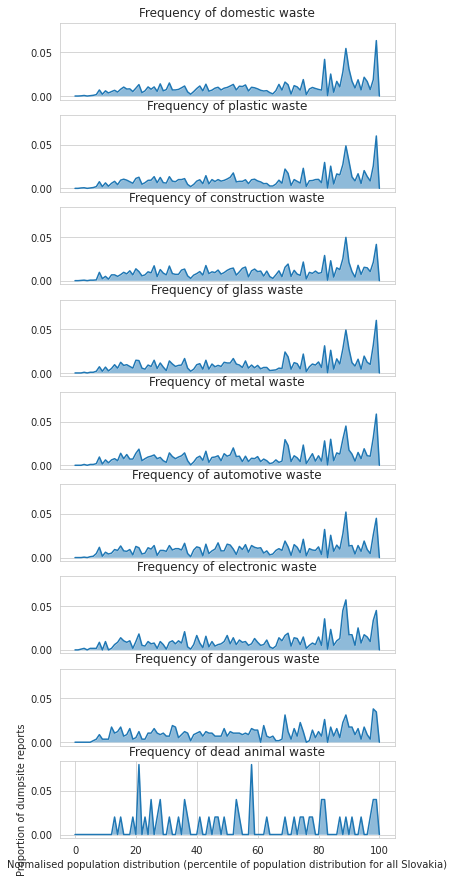

In [ ]:
# # bag_reports = svk_trashout['size'] == 'bag'
# print(svk_trashout['types'].str.contains('plastic', na=False))
# idx = svk_trashout['types'].str.contains('plastic', na=False)
# print(np.unique(idx))
# # print(type(idx[0]))
# print(svk_trashout.loc[idx, 'latitude'])

# Split reports by type of waste
domestic_reports = svk_trashout['types'].str.contains('domestic', na=False)
plastic_reports = svk_trashout['types'].str.contains('plastic', na=False)
construction_reports = svk_trashout['types'].str.contains('construction', na=False)
glass_reports = svk_trashout['types'].str.contains('glass', na=False)
metal_reports = svk_trashout['types'].str.contains('metal', na=False)
automotive_reports = svk_trashout['types'].str.contains('automotive', na=False)
electronic_reports = svk_trashout['types'].str.contains('electronic', na=False)
organic_reports = svk_trashout['types'].str.contains('organic', na=False)
liquid_reports = svk_trashout['types'].str.contains('liquid', na=False)
dangerous_reports = svk_trashout['types'].str.contains('dangerous', na=False)
deadAnimals_reports = svk_trashout['types'].str.contains('deadAnimals', na=False)

# Express population densities as percentiles
domestic_reports_prctile = [np.argmin(abs(d - prctile)) for d in np.array(pop_den)[domestic_reports]]
plastic_reports_prctile = [np.argmin(abs(d - prctile)) for d in np.array(pop_den)[plastic_reports]]
construction_reports_prctile = [np.argmin(abs(d - prctile)) for d in np.array(pop_den)[construction_reports]]
glass_reports_prctile = [np.argmin(abs(d - prctile)) for d in np.array(pop_den)[glass_reports]]
metal_reports_prctile = [np.argmin(abs(d - prctile)) for d in np.array(pop_den)[metal_reports]]
automotive_reports_prctile = [np.argmin(abs(d - prctile)) for d in np.array(pop_den)[automotive_reports]]
electronic_reports_prctile = [np.argmin(abs(d - prctile)) for d in np.array(pop_den)[electronic_reports]]
dangerous_reports_prctile = [np.argmin(abs(d - prctile)) for d in np.array(pop_den)[dangerous_reports]]
deadAnimals_reports_prctile = [np.argmin(abs(d - prctile)) for d in np.array(pop_den)[deadAnimals_reports]]

# Plot
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(nrows=9, ncols=1, sharey=True, figsize=(6,15))
x = np.linspace(0,100,101)

y = [domestic_reports_prctile.count(i)/len(domestic_reports_prctile) for i in x]
ax1.plot(x, y)
ax1.fill_between(x, 0, y, alpha=0.5)
ax1.axes.set_xticks([])

y = [plastic_reports_prctile.count(i)/len(plastic_reports_prctile) for i in x]
ax2.plot(x, y)
ax2.fill_between(x, 0, y, alpha=0.5)
ax2.axes.set_xticks([])
plt.ylabel('Proportion of dumpsite reports')

y = [construction_reports_prctile.count(i)/len(construction_reports_prctile) for i in x]
ax3.plot(x, y)
ax3.fill_between(x, 0, y, alpha=0.5)
ax3.axes.set_xticks([])

y = [glass_reports_prctile.count(i)/len(glass_reports_prctile) for i in x]
ax4.plot(x, y)
ax4.fill_between(x, 0, y, alpha=0.5)
ax4.axes.set_xticks([])

y = [metal_reports_prctile.count(i)/len(metal_reports_prctile) for i in x]
ax5.plot(x, y)
ax5.fill_between(x, 0, y, alpha=0.5)
ax5.axes.set_xticks([])

y = [automotive_reports_prctile.count(i)/len(automotive_reports_prctile) for i in x]
ax6.plot(x, y)
ax6.fill_between(x, 0, y, alpha=0.5)
ax6.axes.set_xticks([])

y = [electronic_reports_prctile.count(i)/len(electronic_reports_prctile) for i in x]
ax7.plot(x, y)
ax7.fill_between(x, 0, y, alpha=0.5)
ax7.axes.set_xticks([])

y = [dangerous_reports_prctile.count(i)/len(dangerous_reports_prctile) for i in x]
ax8.plot(x, y)
ax8.fill_between(x, 0, y, alpha=0.5)
ax8.axes.set_xticks([])

y = [deadAnimals_reports_prctile.count(i)/len(deadAnimals_reports_prctile) for i in x]
ax9.plot(x, y)
ax9.fill_between(x, 0, y, alpha=0.5)
plt.xlabel('Normalised population distribution (percentile of population distribution for all Slovakia)')

ax1.title.set_text('Frequency of domestic waste')
ax2.title.set_text('Frequency of plastic waste')
ax3.title.set_text('Frequency of construction waste')
ax4.title.set_text('Frequency of glass waste')
ax5.title.set_text('Frequency of metal waste')
ax6.title.set_text('Frequency of automotive waste')
ax7.title.set_text('Frequency of electronic waste')
ax8.title.set_text('Frequency of dangerous waste')
ax9.title.set_text('Frequency of dead animal waste')

plt.show()

Domestic waste, unsurprisingly, is might more likely to occur in areas with high population density. The same is true of plastic and glass waste, which might represent casual littering in more populous areas.

Construction, automotive, and electronic waste has some tendency to occur in areas with high population density, but to a lesser degree.

Dangerous waste and dead animals show little association with population density.

# 5. Visualise population density around dumpsite locations
Do dumpsites tend to appear in the middle of cities (i.e. areas of high population density), or on the outskirts, or in smaller towns?

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


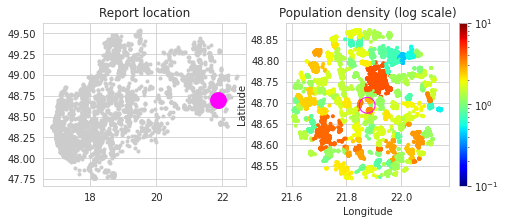

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


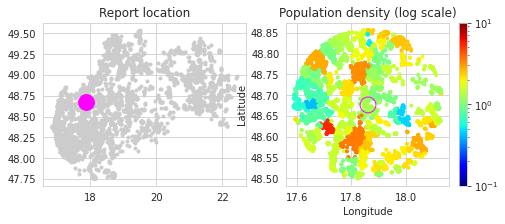

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


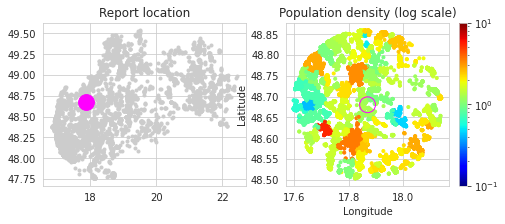

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


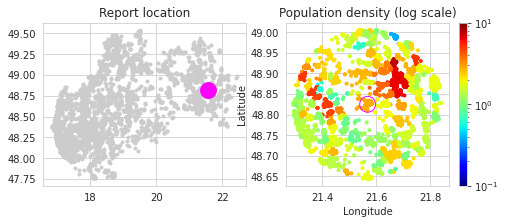

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


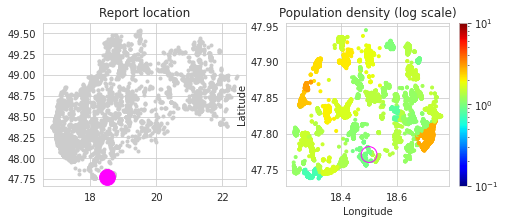

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


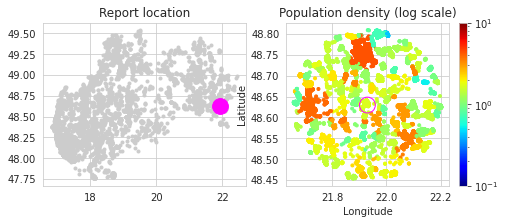

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


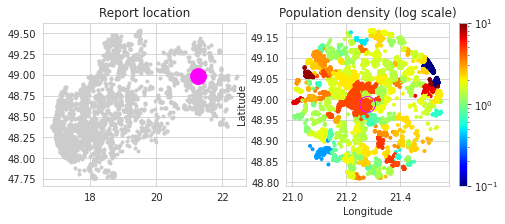

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


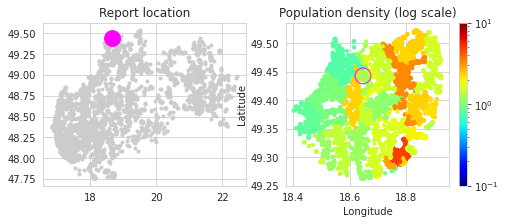

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


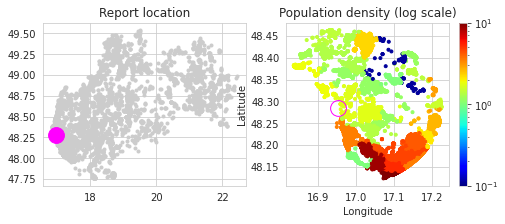

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


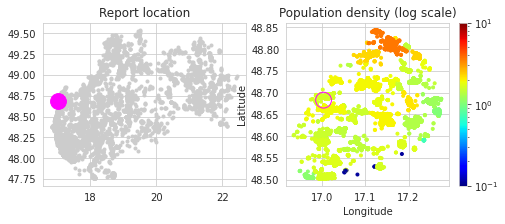

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


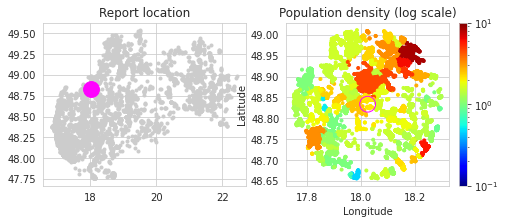

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


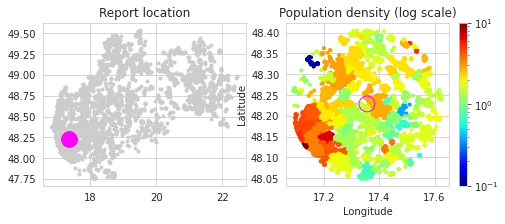

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


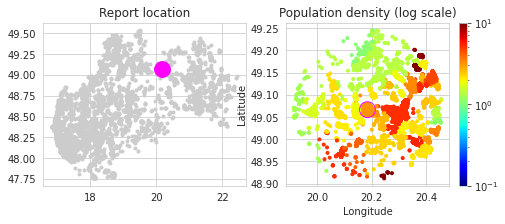

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


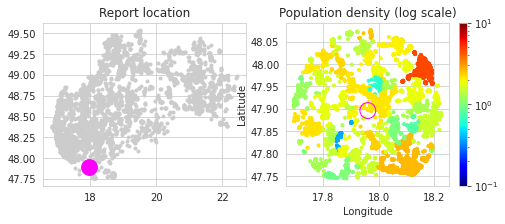

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


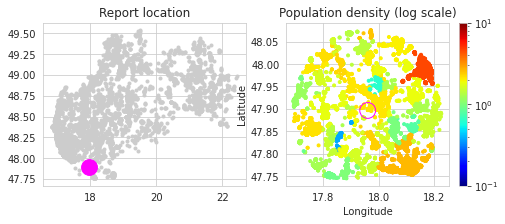

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


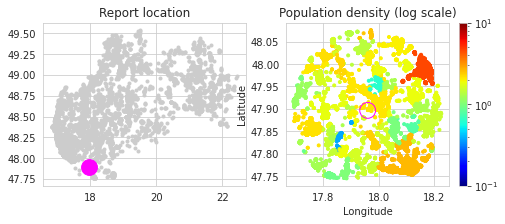

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


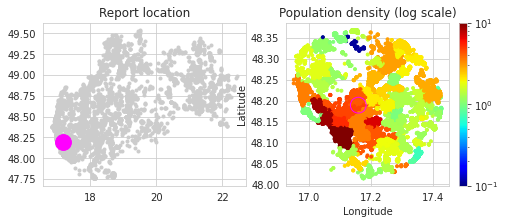

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


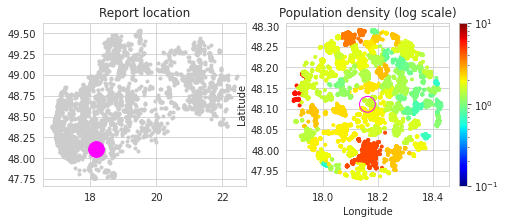

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


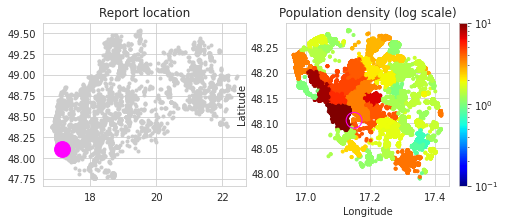

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


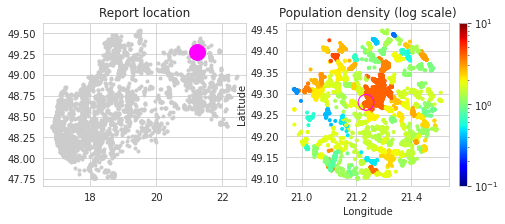

In [ ]:
# Plot a few examples of dumpsites and the population density surrounding it

from matplotlib import colors

for i in range(20):

  # Get report's latitude and longitude
  lat = svk_trashout.iloc[i,2]
  lon = svk_trashout.iloc[i,3]

  # Find distance between report and population density data points using Haversine formula
  dlon = np.radians(lon) - np.radians(svk['Lon'])
  dlat = np.radians(lat) - np.radians(svk['Lat'])
  a = np.sin(dlat/2)**2 + np.cos(np.radians(lat)) * np.cos(np.radians(svk['Lat'])) * np.sin(dlon/2)**2
  d = 6371 * 2 * np.arcsin(np.sqrt(a))

  # Find population density data within 20 km radius
  index_nearby = d < 20

  # Plot where in Slovakia this report is
  plt.figure(figsize=[8, 3])
  ax1 = plt.subplot(1, 2, 1)
  ax1.scatter(x=svk_trashout.loc[:,'longitude'], y=svk_trashout.loc[:,'latitude'], c=[0.8, 0.8, 0.8], marker='.')
  ax1.scatter(x=lon, y=lat, c='magenta', s=250)
  plt.title('Report location')

  # Plot nearby population density
  ax2 = plt.subplot(1, 2, 2)
  sc = ax2.scatter(x=svk.loc[index_nearby,'Lon'], y=svk.loc[index_nearby,'Lat'], c=svk.loc[index_nearby,'Population'], norm=colors.LogNorm(vmin=0.1, vmax=10), marker='.', cmap='jet')
  ax2.scatter(x=lon, y=lat, edgecolors='magenta', s=250, facecolors='none')
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.title('Population density (log scale)')
  plt.colorbar(sc)
  plt.show()


Judging by eye from this small selection, it looks like - with the exception of the large city of Bratislava - there is a tendency for dumpsites to appear on the edge or outside of orange or red patches, i.e. not in city centres.

A notable exception to this seems to be Bratislava, where dumpsites appear in the middle of the city.

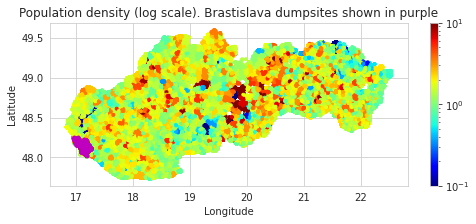

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


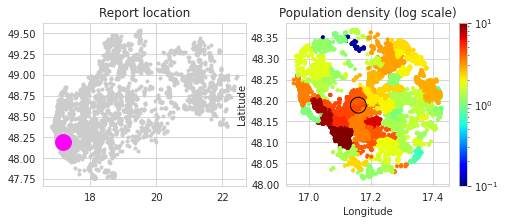

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


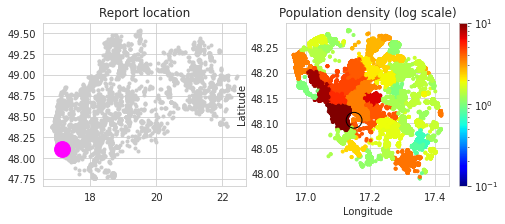

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


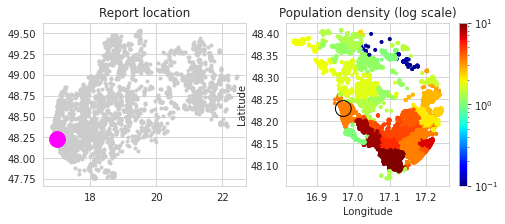

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


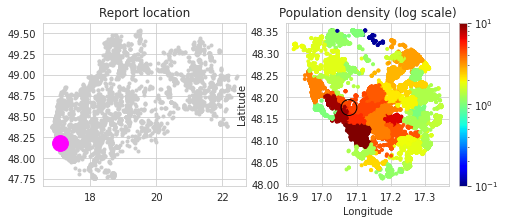

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


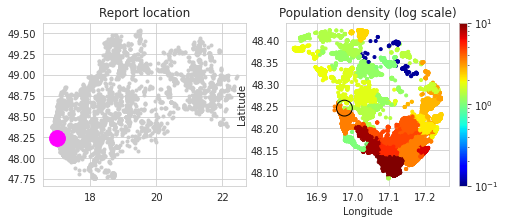

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


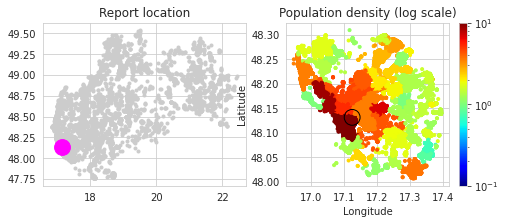

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


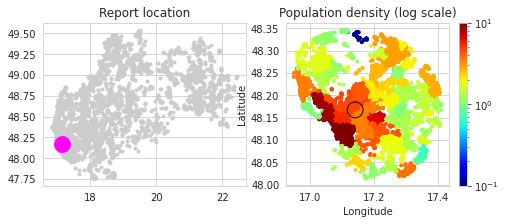

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


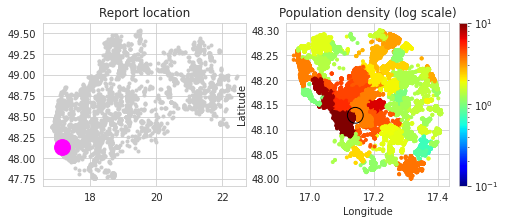

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


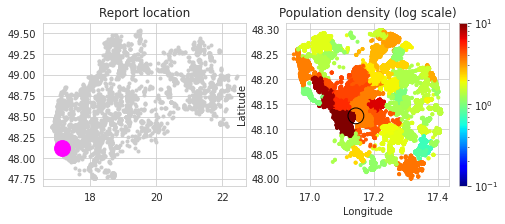

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


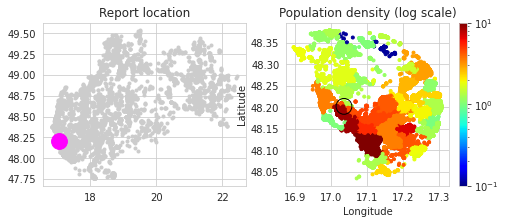

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


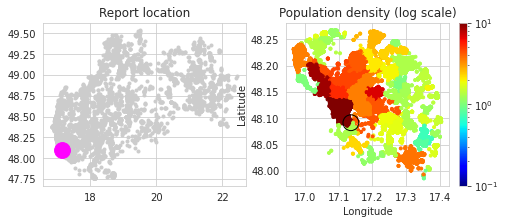

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


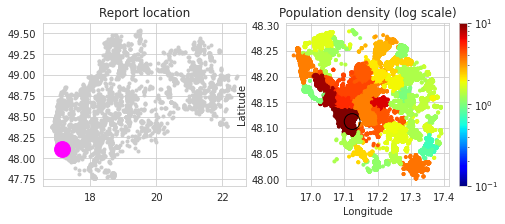

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


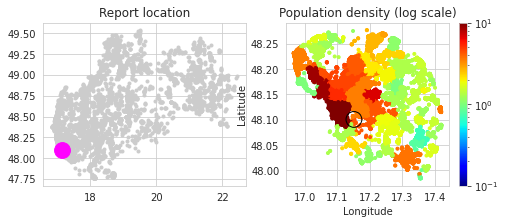

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


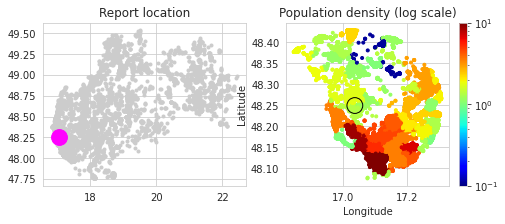

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


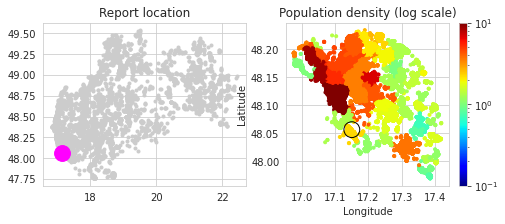

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


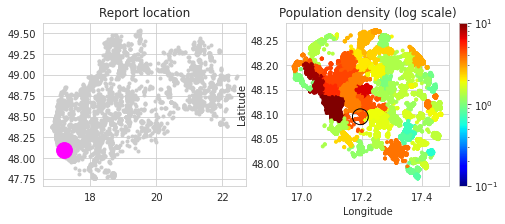

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


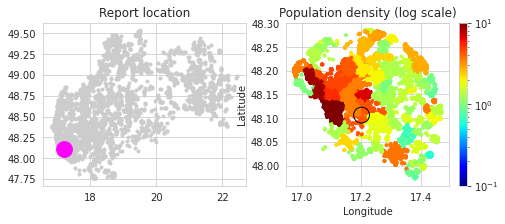

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


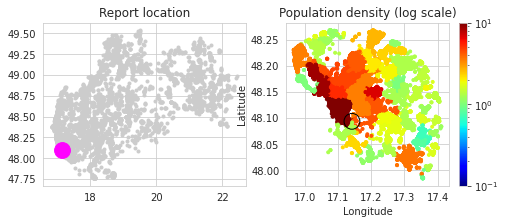

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


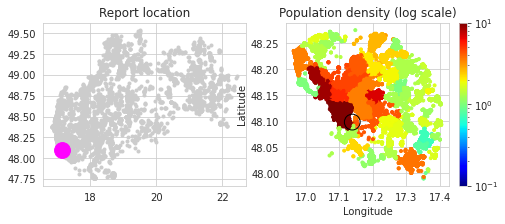

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


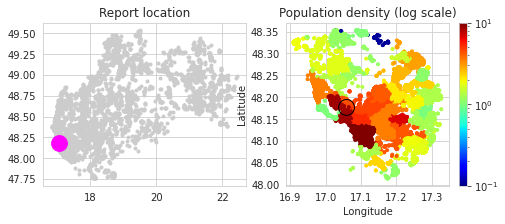

In [ ]:
bratislava_reports = svk_trashout.loc[svk_trashout['locality'] == 'Bratislava',:]

plt.figure(figsize=[8, 3])
ax = plt.subplot(1, 1, 1)
sc = ax.scatter(x=svk.loc[:,'Lon'], y=svk.loc[:,'Lat'], c=svk.loc[:,'Population'], norm=colors.LogNorm(vmin=0.1, vmax=10), marker='.', cmap='jet')
ax.scatter(x=bratislava_reports.loc[:,'longitude'], y=bratislava_reports.loc[:,'latitude'], c='m', marker = '.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Population density (log scale). Brastislava dumpsites shown in purple')
plt.colorbar(sc)
plt.show()

for i in range(20):

  # Get report's latitude and longitude
  lat = bratislava_reports.iloc[i,2]
  lon = bratislava_reports.iloc[i,3]

  # Find distance between report and population density data points using Haversine formula
  dlon = np.radians(lon) - np.radians(svk['Lon'])
  dlat = np.radians(lat) - np.radians(svk['Lat'])
  a = np.sin(dlat/2)**2 + np.cos(np.radians(lat)) * np.cos(np.radians(svk['Lat'])) * np.sin(dlon/2)**2
  d = 6371 * 2 * np.arcsin(np.sqrt(a))

  # Find population density data within 20 km radius
  index_nearby = d < 20

  # Plot where in Slovakia this report is
  plt.figure(figsize=[8, 3])
  ax1 = plt.subplot(1, 2, 1)
  ax1.scatter(x=svk_trashout.loc[:,'longitude'], y=svk_trashout.loc[:,'latitude'], c=[0.8, 0.8, 0.8], marker='.')
  ax1.scatter(x=lon, y=lat, c='magenta', s=250)
  plt.title('Report location')

  # Plot nearby population density
  ax2 = plt.subplot(1, 2, 2)
  sc = ax2.scatter(x=svk.loc[index_nearby,'Lon'], y=svk.loc[index_nearby,'Lat'], c=svk.loc[index_nearby,'Population'], norm=colors.LogNorm(vmin=0.1, vmax=10), marker='.', cmap='jet')
  ax2.scatter(x=lon, y=lat, edgecolors='black', s=250, facecolors='none')
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.title('Population density (log scale)')
  plt.colorbar(sc)
  plt.show()

Contrary to dumpsites in the rest of Slovakia, dumpsites in Bratislava appear scattered throughout the city, both in areas of high population density and on the outskirts.